# 資料集「胸部加速度器」
x:x軸加速
y:y軸加速
z:z軸加速
activity(1:在電腦前工作；2:站立、走路和上下樓梯；3:站立；4:走路；5:上下樓梯；6:與人邊走邊聊；7:站立著講話

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('./data/1.csv',header=None)
df.columns = ['index', 'x', 'y', 'z', 'activity']
df.head()

,index,x,y,z,activity
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1


In [3]:
df.shape

(162501, 5)

#### 目標行是activity，觀察空準確率(null accuracy)

In [4]:
df['activity'].value_counts(normalize=True)

7    0.515369
1    0.207242
4    0.165291
3    0.068793
5    0.019637
6    0.017951
2    0.005711
0    0.000006
Name: activity, dtype: float64

#### 建立分類模型

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

X = df[['x', 'y', 'z']]
y = df['activity']

knn_params = {'n_neighbors':[3, 4, 5, 6]}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, knn_params)
grid.fit(X, y)

print(grid.best_score_, grid.best_params_)

c:\python38\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


0.7408140649873495 {'n_neighbors': 5}


# 多項式特徵

利用原先的特徵，做特徵之間的「乘積」，觀察特徵之間的「互動」情形(feature interactions)。就是利用原先特徵的「多項式組合」(polynominal combinations)

運用scikit-learn的Polynominal Features。參數:
- degree:多項式特徵的階數。假設特徵為[a, b]，二項式特徵就是小於等於指定階數的組合，[1, a, b, a^2, ab, b^2]。
- interaction_only: 如果是True，只產生特徵之間有互動的多項式，也就是不同階數特徵的乘積
- include_bias: 會產生一行階數為0的偏差行，該行中所有數值都為1。

In [6]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

In [7]:
#擬合
X_poly = poly.fit_transform(X)
X_poly.shape

(162501, 9)

In [8]:
#觀察特徵
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
0,1502.0,2215.0,2153.0,2256004.0,3326930.0,3233806.0,4906225.0,4768895.0,4635409.0
1,1667.0,2072.0,2047.0,2778889.0,3454024.0,3412349.0,4293184.0,4241384.0,4190209.0
2,1611.0,1957.0,1906.0,2595321.0,3152727.0,3070566.0,3829849.0,3730042.0,3632836.0
3,1601.0,1939.0,1831.0,2563201.0,3104339.0,2931431.0,3759721.0,3550309.0,3352561.0
4,1643.0,1965.0,1879.0,2699449.0,3228495.0,3087197.0,3861225.0,3692235.0,3530641.0


### 探索式資料分析
「多項式特徵」其實是要觀察特徵之間的互動情況，利用「關聯熱區圖觀察」

In [9]:
import matplotlib as plt
%matplotlib inline
import seaborn as sns

<AxesSubplot:>

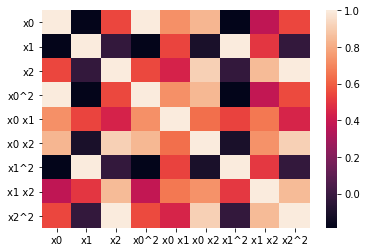

In [10]:
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr())

In [11]:
#將interaction_only設成True，只顯示有互動的特徵
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_poly = poly.fit_transform(X)
X_poly.shape

(162501, 6)

In [12]:
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,x0,x1,x2,x0 x1,x0 x2,x1 x2
0,1502.0,2215.0,2153.0,3326930.0,3233806.0,4768895.0
1,1667.0,2072.0,2047.0,3454024.0,3412349.0,4241384.0
2,1611.0,1957.0,1906.0,3152727.0,3070566.0,3730042.0
3,1601.0,1939.0,1831.0,3104339.0,2931431.0,3550309.0
4,1643.0,1965.0,1879.0,3228495.0,3087197.0,3692235.0


<AxesSubplot:>

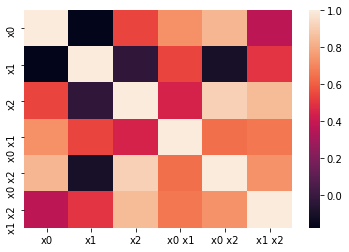

In [13]:
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr())

### 建立管線

In [14]:
from sklearn.pipeline import Pipeline

In [15]:
# 設置管線參數
pipe_params = {'poly_features__degree':[1,2,3],
              'poly_features__interaction_only':[True, False],
              'classify__n_neighbors':[3,4,5,6]}

#產生實體管線
pipe = Pipeline([('poly_features', poly), ('classify', knn)])

#設置網格搜尋
grid = GridSearchCV(pipe, pipe_params)
grid.fit(X, y)

print(grid.best_score_, grid.best_params_)

c:\python38\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


0.7408140649873495 {'classify__n_neighbors': 5, 'poly_features__degree': 1, 'poly_features__interaction_only': True}
